In [2]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [88]:
def depict_Kline(df,label):
    '''
    ##绘制k线图
    ##输入：DataFrame  index是日期（0-5） column是高开低收
    ##输出：画出每一天的k线图
    '''
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 计算K线实体高度和影线长度
    df['body'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_shadow'] = df[['open', 'close']].min(axis=1) - df['low']
    
    # 设置涨跌颜色（红色表示上涨，绿色表示下跌）
    colors = ['red' if close >= open else 'green' for close, open in zip(df['close'], df['open'])]
    
    # 绘制K线
    for i, (index, row) in enumerate(df.iterrows()):
        # 使用索引作为X坐标
        x_pos = index
        
        # 绘制实体
        ax.bar(
            x_pos, row['body'], 
            bottom=min(row['open'], row['close']), 
            width=0.6, color=colors[i], alpha=0.8
        )
        
        # 绘制上影线和下影线
        ax.plot([x_pos, x_pos], 
                [row['high'], max(row['open'], row['close'])], 
                color='black', linewidth=1)
        ax.plot([x_pos, x_pos], 
                [min(row['open'], row['close']), row['low']], 
                color='black', linewidth=1)
    
    # 设置X轴刻度为索引值
    ax.set_xticks(df.index)
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # 设置标题和标签
    ax.set_title('K线图', fontsize=16)
    ax.set_xlabel('交易日', fontsize=12)
    ax.set_ylabel('价格', fontsize=12)
    
    # 添加图例
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', edgecolor='black', label='上涨'),
        Patch(facecolor='green', edgecolor='black', label='下跌')
    ]
    ax.legend(handles = legend_elements, loc='upper left')
    plt.gca().legend([label])
    # 调整布局
    plt.tight_layout()
    
    return fig, ax

In [3]:
def process_indicator(data, indicator_name):
    # stack()：将列（股票ID）转为行，形成（时间, 股票ID）的二级索引
    long_df = data.stack(dropna = True).reset_index()
    # 重命名列：股票ID、时间、指标值
    long_df.columns = ['stock_id', 'time', 'value']
    # 添加指标类型列（如'post'、'high'）
    long_df['indicator'] = indicator_name
    return long_df

In [96]:
###预处理 拼成长表
post_data = ff.read('post') * ff.filter0
high_data = ff.read('high') * post_data * ff.filter0
low_data = ff.read('low') * post_data * ff.filter0
close_data = ff.read('close') * post_data * ff.filter0
open_data = ff.read('open') * post_data * ff.filter0
uplimit_data = (ff.read('up_limit') * post_data * ff.filter0)


df_high = process_indicator(high_data, 'high')
df_low = process_indicator(low_data, 'low')
df_close = process_indicator(close_data, 'close')
df_open = process_indicator(open_data, 'open')
df_uplimit = process_indicator(uplimit_data, 'uplimit')

long_table = pd.concat(
    [df_high, df_low, df_close, df_open, df_uplimit],
    ignore_index=True
)

In [100]:
stock_list = long_table['stock_id'].unique().tolist()

In [101]:
def init_worker(table):
    global shared_table
    shared_table = table

init_worker(long_table)

In [7]:
def climax_find(df):
    '''
    找到局部极值点
    ##输入：DataFrame index是日期 columns是high low open close
    ##输出：DataFrame index是日期 columns是high low open close peak
    # 创建peak列，默认值为NaN
    '''
    
    df['peak'] = np.nan
    
    for i in range(len(df)):
        # 确定查找范围（防止越界）
        start = max(0, i - 1)
        end = min(len(df), i + 2)
        
        # 使用loc通过标签索引列
        current_high = df.loc[df.index[i], 'high']
        range_highs = df.loc[df.index[start:end], 'high']
        
        # 判断当前是否为局部高点
        if current_high == range_highs.max():
            df.loc[df.index[i], 'peak'] = 'high'
            continue  # 找到高点后继续下一个点
            
        # 判断当前是否为局部低点
        current_low = df.loc[df.index[i], 'low']
        range_lows = df.loc[df.index[start:end], 'low']
        
        if current_low == range_lows.min():
            df.loc[df.index[i], 'peak'] = 'low'
    
    return df

In [8]:
def platform_find(df):
    """
    查找价格平台（以当前K线为最新K线的平台高点）
    
    参数:
    df (pd.DataFrame): 包含K线数据的DataFrame，索引可为任意类型，
                      列包含'high', 'low', 'open', 'close', 'peak'
    
    返回:
    pd.DataFrame: 添加了'platform'列的DataFrame，记录平台高点和平台长度
    """
    # 创建platform列，默认值为NaN
    df['platform'] = np.nan
    df['platform_length'] = np.nan
    
    # 获取列的位置索引（确保兼容任意索引类型）
    peak_col = df.columns.get_loc('peak')
    low_col = df.columns.get_loc('low')
    high_col = df.columns.get_loc('high')
    
    # 遍历每一行（从第1行开始，0-based索引）
    for i in range(1, len(df)):
        current_high_low = None  # 最近高点对应的低点
        current_low_high = None  # 最近低点对应的高点
        
        # 向前查找（从i-1到0）
        for j in range(i-1, -1, -1):
            # 使用iloc按位置访问，避免索引类型问题
            peak_val = df.iloc[j, peak_col]
            
            if peak_val == 'high':
                current_high_low = df.iloc[j, low_col]
            elif peak_val == 'low':
                current_low_high = df.iloc[j, high_col]
            
            # 当同时找到有效高点和低点，且满足高低点条件时
            if (current_high_low is not None and 
                current_low_high is not None and 
                current_high_low < current_low_high):
                
                # 计算j到i区间内的最高值作为平台高点
                platform_high = df.iloc[j:i, high_col].max()
                df.iloc[i, df.columns.get_loc('platform')] = platform_high
                df.iloc[i, df.columns.get_loc('platform_length')] = i - j
                break  # 找到平台后跳出内层循环
    
    return df

In [97]:
def run(df, start_date, end_date, stock_id):
    """
    回测函数（按platform_length分类计算）
    输入：DataFrame 对应一支股票，index是日期，columns包含 high, low, open, close, platform, uplimit, platform_length
    输出：DataFrame 长表格式，columns=['stock_id', 'time', 'platform_length','open','close','high','low']
    """
    # 1. 筛选基础符合条件的交易日（包含platform_length）
    df['valid'] = (df['high'] > df['platform']) & (df['uplimit'] != df['close']) &  (df.index >= start_date) & (df.index <= end_date) & (df['platform_length'].notna())
    df['valid'] = df['valid'].fillna(False)
    df['platform_length'] = df['platform_length']
    valid_days = df[df['valid']]  # 确保platform_length非空
    # 2. 初始化结果列表
    result_data = []
    
    # 3. 遍历每个有效交易日
    for idx in valid_days.index:
        # 获取平台长度并转换为分类
        platform_length = valid_days.loc[idx, 'platform_length']
        if pd.isna(platform_length):
            continue
            
        # 确定分类
        if platform_length == 2:
            category = '2'
        elif platform_length == 3:
            category = '3'
        elif platform_length == 4:
            category = '4'
        elif platform_length == 5:
            category = '5'
        elif platform_length == 6:
            category = '6'
        else:  # >=7
            category = '≥7'
        
        num_index = df.index.get_loc(idx)
        base_price = df.loc[idx]['open']
        try:
            open1 = df.iloc[num_index]['open'] / base_price
            open2 = df.iloc[num_index + 1]['open'] / base_price
            open3 = df.iloc[num_index + 2]['open'] / base_price
            open4 = df.iloc[num_index + 3]['open'] / base_price
            open5 = df.iloc[num_index + 4]['open'] / base_price
            open6 = df.iloc[num_index + 5]['open'] / base_price

            close1 = df.iloc[num_index]['close'] / base_price
            close2 = df.iloc[num_index + 1]['close'] / base_price
            close3 = df.iloc[num_index + 2]['close'] / base_price
            close4 = df.iloc[num_index + 3]['close'] / base_price
            close5 = df.iloc[num_index + 4]['close'] / base_price
            close6 = df.iloc[num_index + 5]['close'] / base_price

            high1 = df.iloc[num_index]['high'] / base_price
            high2 = df.iloc[num_index + 1]['high'] / base_price
            high3 = df.iloc[num_index + 2]['high'] / base_price
            high4 = df.iloc[num_index + 3]['high'] / base_price
            high5 = df.iloc[num_index + 4]['high'] / base_price
            high6 = df.iloc[num_index + 5]['high'] / base_price

            low1 = df.iloc[num_index]['low'] / base_price
            low2 = df.iloc[num_index + 1]['low'] / base_price
            low3 = df.iloc[num_index + 2]['low'] / base_price
            low4 = df.iloc[num_index + 3]['low'] / base_price
            low5 = df.iloc[num_index + 4]['low'] / base_price
            low6 = df.iloc[num_index + 5]['low'] / base_price
        except:
            continue
        # 添加到结果列表
        result_data.append({
            'stock_id': stock_id,
            'time': idx,
            'platform_length': category,
            'open1':open1,
            'open2':open2,
            'open3':open3,
            'open4':open4,
            'open5':open5,
            'open6':open6,
            'close1': close1,
            'close2': close2,
            'close3': close3,
            'close4': close4,
            'close5': close5,
            'close6': close6,
            'high1': high1,
            'high2': high2,
            'high3': high3,
            'high4': high4,
            'high5': high5,
            'high6': high6,
            'low1': low1,
            'low2': low2,
            'low3': low3,
            'low4': low4,
            'low5': low5,
            'low6': low6
        })
    
    # 4. 转换为DataFrame并返回
    return pd.DataFrame(result_data)

In [98]:
def stock_process(stock_id,start_date = '2020-01-03',end_date = '2025-07-10'):
    ##输入：单只股票的DataFrame index:日期 columns：高开低收
    ##输出：stock_id对应的所有信号df
    df = shared_table[shared_table['stock_id'] == stock_id]
    if not df.empty:
        stock_data = df.pivot(index='time',
                            columns='indicator',
                            values='value')
        stock_data.index = pd.to_datetime(stock_data.index)
        stock_data = climax_find(stock_data)
        stock_data = platform_find(stock_data)
        res_df = run(stock_data,start_date,end_date,stock_id)
        return res_df
    else:
        return pd.DataFrame

In [102]:
stock_process('000001.SZ')

,stock_id,time,platform_length,open1,open2,open3,open4,open5,open6,close1,...,high3,high4,high5,high6,low1,low2,low3,low4,low5,low6
0,000001.SZ,2020-01-03,4,1.0,1.004132,1.011216,1.003542,0.992326,0.991145,1.014168,...,1.020071,1.006494,0.999410,0.992326,0.998819,0.998229,1.000590,0.981700,0.975797,0.975207
1,000001.SZ,2020-01-06,5,1.0,1.007055,0.999412,0.988242,0.987066,0.984715,1.003527,...,1.002352,0.995297,0.988242,1.001176,0.994121,0.996473,0.977660,0.971781,0.971193,0.976484
2,000001.SZ,2020-02-11,4,1.0,1.013014,1.007534,1.010274,1.030137,1.050000,1.013014,...,1.019178,1.036986,1.052740,1.050000,0.997260,1.000000,1.000685,1.006849,1.022603,1.028082
3,000001.SZ,2020-02-14,≥7,1.0,1.019661,1.039322,1.023729,1.035254,1.050169,1.018983,...,1.039322,1.042034,1.058983,1.065763,0.996610,1.012203,1.017627,1.022373,1.023729,1.047458
4,000001.SZ,2020-02-17,≥7,1.0,1.019282,1.003989,1.015293,1.029920,1.027926,1.021941,...,1.021941,1.038564,1.045213,1.027926,0.992686,0.998005,1.002660,1.003989,1.027261,1.007314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,000001.SZ,2025-06-26,≥7,1.0,1.026556,1.007469,1.000830,1.021577,1.023237,1.029876,...,1.009959,1.023237,1.029876,1.030705,0.996680,1.006639,0.992531,1.000830,1.014938,1.019087
267,000001.SZ,2025-06-27,≥7,1.0,0.981407,0.974939,0.995150,0.996766,0.998383,0.986257,...,0.996766,1.003234,1.004042,1.028294,0.980598,0.966855,0.974939,0.988682,0.992724,0.994341
268,000001.SZ,2025-07-04,5,1.0,1.020243,1.032389,1.025101,1.038057,1.068016,1.020243,...,1.039676,1.044534,1.079352,1.076923,0.995951,1.020243,1.024291,1.025101,1.035628,1.043725
269,000001.SZ,2025-07-07,6,1.0,1.011905,1.004762,1.017460,1.046825,1.021429,1.014286,...,1.023810,1.057937,1.055556,1.045238,1.000000,1.003968,1.004762,1.015079,1.023016,1.020635


In [103]:
'''
Task5:记突破平台的时间是0,记录6天内的平均收益 根据平台长度分类绘制K线图(先求日内平均 再求日间平均)
'''

with Pool(96, initializer = init_worker, initargs=(long_table,)) as p:
    # 直接使用 stock_process，不需要 partial
    res_lst = list(tqdm(p.imap(stock_process, stock_list), total = len(stock_list)))  ##一个list 元素是每支股票的所有信号

final_df = pd.concat(res_lst, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5106/5106 [06:06<00:00, 13.92it/s]


In [73]:
final_df

,stock_id,time,platform_length,open1,open2,open3,open4,open5,open6,close1,...,high3,high4,high5,high6,low1,low2,low3,low4,low5,low6
0,000001.SZ,2020-01-03,4,1.0,1.004132,1.011216,1.003542,0.992326,0.991145,1.014168,...,1.020071,1.006494,0.999410,0.992326,0.998819,0.998229,1.000590,0.981700,0.975797,0.975207
1,000001.SZ,2020-01-06,5,1.0,1.007055,0.999412,0.988242,0.987066,0.984715,1.003527,...,1.002352,0.995297,0.988242,1.001176,0.994121,0.996473,0.977660,0.971781,0.971193,0.976484
2,000001.SZ,2020-02-11,4,1.0,1.013014,1.007534,1.010274,1.030137,1.050000,1.013014,...,1.019178,1.036986,1.052740,1.050000,0.997260,1.000000,1.000685,1.006849,1.022603,1.028082
3,000001.SZ,2020-02-14,≥7,1.0,1.019661,1.039322,1.023729,1.035254,1.050169,1.018983,...,1.039322,1.042034,1.058983,1.065763,0.996610,1.012203,1.017627,1.022373,1.023729,1.047458
4,000001.SZ,2020-02-17,≥7,1.0,1.019282,1.003989,1.015293,1.029920,1.027926,1.021941,...,1.021941,1.038564,1.045213,1.027926,0.992686,0.998005,1.002660,1.003989,1.027261,1.007314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150107,689009.SH,2025-05-22,≥7,1.0,1.017994,0.983656,0.982156,0.964612,0.967161,1.017394,...,0.989654,0.987554,0.975409,1.007048,0.993852,0.992053,0.971660,0.956365,0.956365,0.965212
1150108,689009.SH,2025-05-23,≥7,1.0,0.966269,0.964796,0.947562,0.950066,0.942849,0.974665,...,0.970099,0.958168,0.989247,0.973339,0.974518,0.954485,0.939461,0.939461,0.948151,0.942849
1150109,689009.SH,2025-06-03,2,1.0,1.019659,1.005639,1.005791,0.944834,0.956721,1.014934,...,1.011887,1.018287,0.960530,0.963578,0.990856,0.997867,0.990552,0.929595,0.930204,0.939043
1150110,689009.SH,2025-06-23,3,1.0,0.977955,0.987568,0.979612,0.961213,0.962208,0.977955,...,0.987734,0.984585,0.974308,0.986242,0.955743,0.971490,0.963037,0.960053,0.956406,0.957567


In [104]:
grouped_df = final_df.groupby(['time', 'platform_length'])[['open1','open2','open3','open4','open5','open6',
                                                            'close1','close2','close3','close4','close5','close6',
                                                           'high1','high2','high3','high4','high5','high6',
                                                           'low1','low2','low3','low4','low5','low6']].mean().reset_index()

In [105]:
paint_df = grouped_df.groupby(['platform_length'])[['open1','open2','open3','open4','open5','open6',
                                                            'close1','close2','close3','close4','close5','close6',
                                                           'high1','high2','high3','high4','high5','high6',
                                                           'low1','low2','low3','low4','low5','low6']].mean().reset_index()

In [106]:
def split_platform_data(df):
    """
    将包含多日数据的宽表 DataFrame 拆分为多个按 platform_length 分组的 DataFrame
    
    参数:
    df: 输入的 DataFrame，包含 platform_length 列和 open1-6, close1-6, high1-6, low1-6 列
    
    返回:
    dict: 键为 platform_length 的唯一值，值为对应的 DataFrame
    """
    # 获取 platform_length 的唯一值
    unique_platforms = df['platform_length'].unique()
    
    # 初始化结果字典
    result = {}
    
    # 遍历每个 platform_length 值
    for platform in unique_platforms:
        # 筛选当前 platform_length 的数据
        platform_df = df[df['platform_length'] == platform].copy()
        
        # 创建新的 DataFrame，用于存储整理后的数据
        new_df = pd.DataFrame()
        
        # 遍历第1天到第6天
        for day in range(1, 7):
            # 提取当前天的 open, close, high, low 数据
            day_data = {
                'open': platform_df[f'open{day}'].values[0],
                'close': platform_df[f'close{day}'].values[0],
                'high': platform_df[f'high{day}'].values[0],
                'low': platform_df[f'low{day}'].values[0]
            }
            
            # 添加到新的 DataFrame 中，索引为 day
            new_df = pd.concat([new_df, pd.DataFrame(day_data, index=[day])])
        
        # 将整理后的 DataFrame 添加到结果字典中
        result[platform] = new_df
    
    return result


In [107]:
paint_dict = split_platform_data(paint_df)

In [108]:
paint_dict

{'2':        open     close      high       low
 1  1.000000  1.023061  1.044295  0.990447
 2  1.020544  1.021972  1.044744  0.999692
 3  1.020052  1.020535  1.043229  0.999461
 4  1.019433  1.020801  1.042790  0.999404
 5  1.019620  1.020929  1.042840  0.999749
 6  1.019965  1.021020  1.043250  0.999736,
 '3':        open     close      high       low
 1  1.000000  1.017665  1.040302  0.986673
 2  1.015132  1.017243  1.039800  0.994870
 3  1.015751  1.016675  1.039174  0.995399
 4  1.015603  1.017025  1.039172  0.995573
 5  1.015994  1.016973  1.039347  0.995733
 6  1.015954  1.017173  1.039227  0.995907,
 '4':        open     close      high       low
 1  1.000000  1.016737  1.041119  0.985031
 2  1.013937  1.015717  1.039263  0.992918
 3  1.013933  1.015295  1.038286  0.993302
 4  1.013983  1.015200  1.038122  0.993318
 5  1.013916  1.015086  1.037707  0.993291
 6  1.014081  1.015044  1.037683  0.993466,
 '5':        open     close      high       low
 1  1.000000  1.016158  1.04197

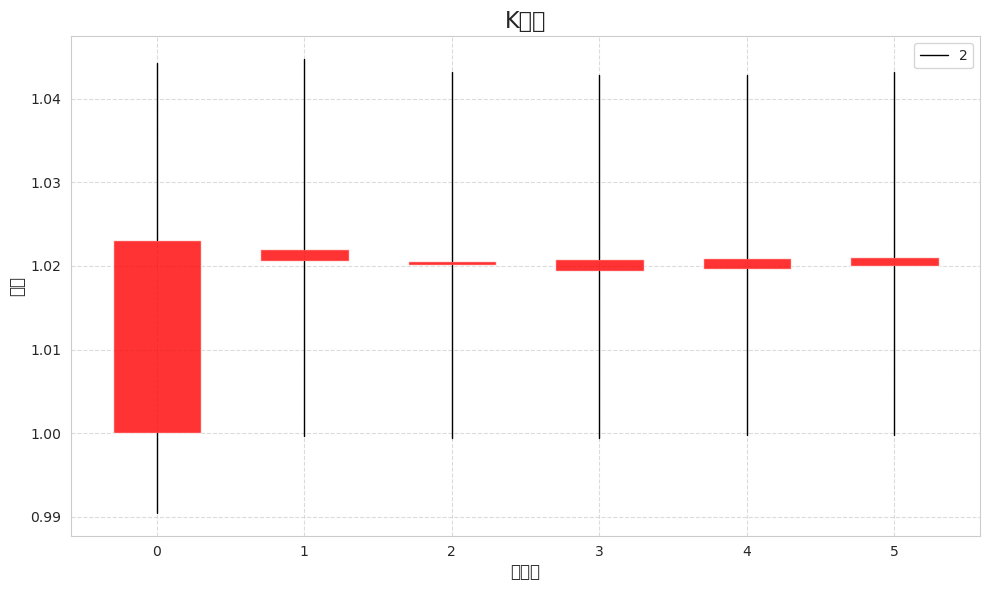

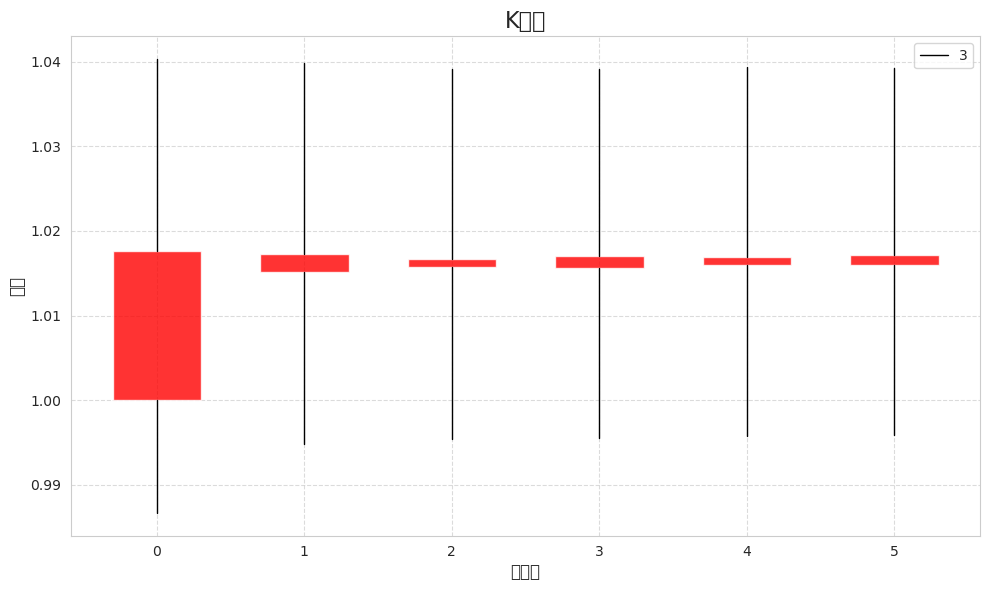

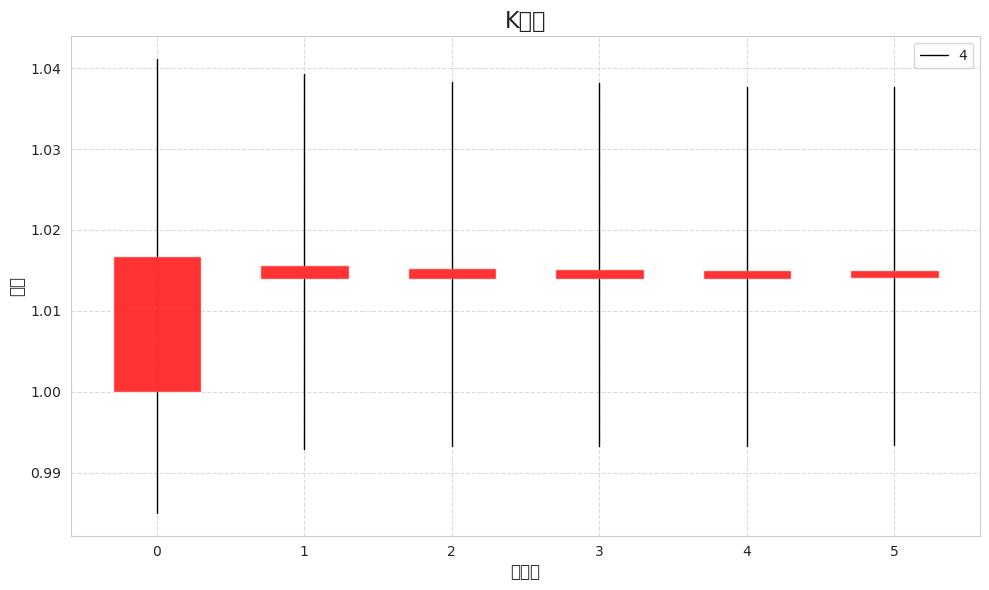

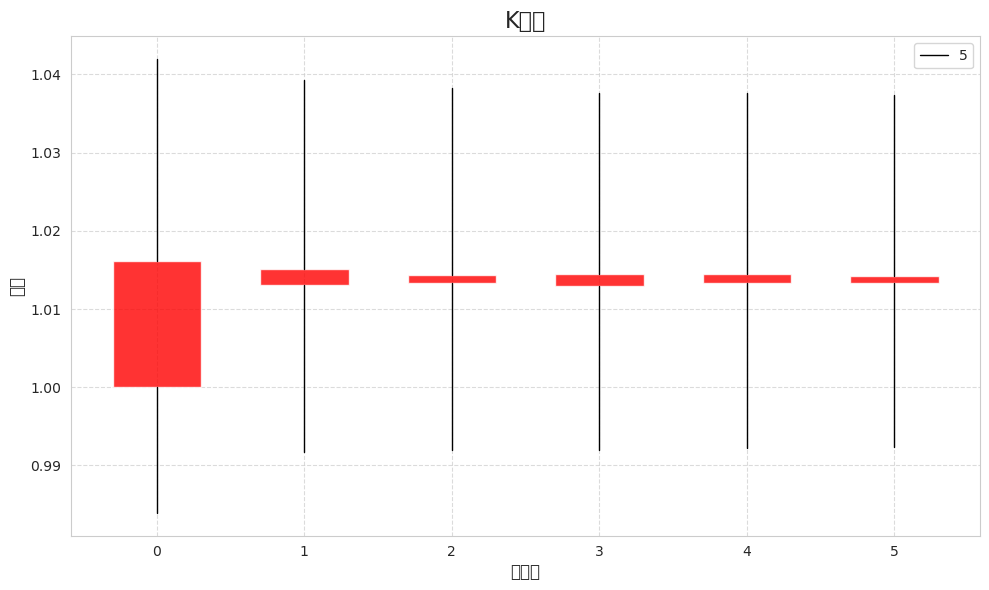

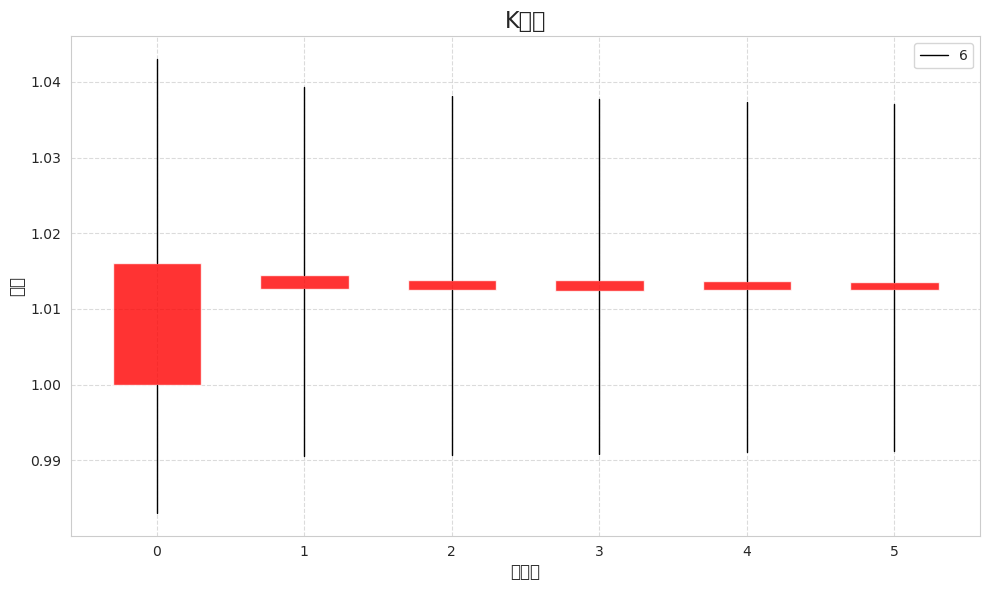

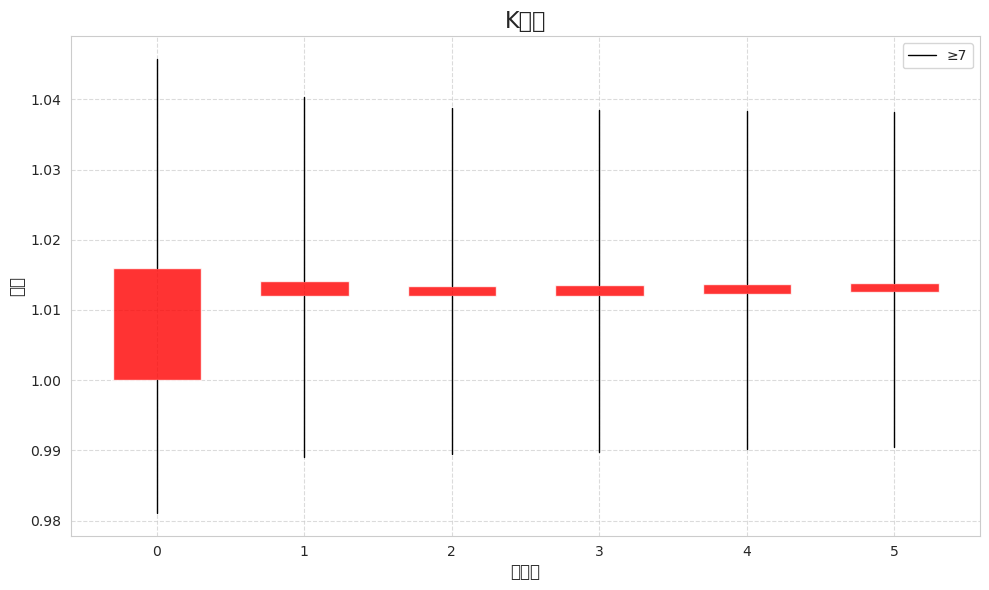

In [109]:
for i in ['2','3','4','5','6','≥7']:
    ddff = paint_dict[i].reset_index()
    depict_Kline(ddff,i)

In [110]:
ddff

,index,open,close,high,low,body,upper_shadow,lower_shadow
0,1,1.000000,1.016023,1.045746,0.981066,0.016023,0.029723,0.018934
1,2,1.011984,1.014191,1.040290,0.989062,0.002208,0.026098,0.022922
2,3,1.011938,1.013433,1.038829,0.989455,0.001494,0.025396,0.022483
3,4,1.011961,1.013619,1.038450,0.989824,0.001657,0.024831,0.022137
4,5,1.012326,1.013704,1.038293,0.990182,0.001378,0.024589,0.022144
5,6,1.012539,1.013874,1.038221,0.990527,0.001336,0.024346,0.022011
